In [2]:
import pandas as pd
import xarray as xr
from fos import util
from fos.data import snotelmeta 
import datetime
import os
import numpy as np
from fos.util import get_wrf_data_points
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('style.mplstyle')
mpl.rcParams['axes.linewidth'] = 1
## 
def wrfread(datadir, gcm, exp, variant, domain, var):
    modeldir = datadir + gcm + '/postprocess/'+domain + '/'
    all_files = sorted(os.listdir(modeldir))
    read_files = []
    for ii in all_files:
        if (
            ii.startswith(var + ".")
            and model in ii
            and variant in ii
            and domain in ii
        ):
            if domain in ii:
                read_files.append(os.path.join(modeldir, str(ii)))
    assert len(read_files) > 0, f"No matching files found in {modeldir}"

    del all_files

    data = xr.open_mfdataset(read_files, combine="by_coords")
    var_read = data.variables[var]

    dates = []
    for val in data["day"].data:
        try:
            dates.append(datetime.datetime.strptime(str(val)[0:-2], "%Y%m%d").date())
        except ValueError:
            dates.append(datetime.datetime(int(str(val)[0:4]), int(str(val)[4:6]), 28))


    var_read = xr.DataArray(var_read, dims=["day", "lat2d", "lon2d"])
    var_read["day"] = dates
    return var_read

## load data  
var = 'snow'
modeldir = '/glade/campaign/uwyo/wyom0112/postprocess/'
model = 'ukesm1-0-ll'
variant = 'r2i1p1f2'
domain = 'd02'
basedir = '/glade/u/home/mcowherd/'
projectdir = basedir + 'fos-data/'
snoteldir = projectdir + 'snoteldata/'
wrfdir = '/glade/campaign/uwyo/wyom0112/postprocess/'
wrfcoorddir = projectdir 
domain = "d02"

## LOAD DATA ## 
mod_historical = model +'_'+ variant + '_historical_bc'
mod_future = model +'_' + variant+ '_ssp370_bc'
gcm = mod_historical
date_start_pd, date_end_pd = [1980, 1, 1], [2013, 12, 31]  # 30 years, historical
exp = "hist"
var_wrf = wrfread(modeldir, gcm, exp, variant, domain, var)
var_wrf = util.screen_times_wrf(var_wrf, date_start_pd, date_end_pd)

# future dates
date_start_pd, date_end_pd = [2014, 1, 1], [2100, 12, 31]
gcm = mod_future
model = "ssp370"
var_wrf_ssp370 = wrfread(modeldir, gcm, model, variant, domain, var)
var_wrf_ssp370 = util.screen_times_wrf(var_wrf_ssp370, date_start_pd, date_end_pd)

wrfdata = [var_wrf, var_wrf_ssp370]

coords = util.get_coords(wrfcoorddir+'/wrf_coordinates')

lon_wrf = coords['lon2d']
lat_wrf = coords['lat2d']

subregions = ["SW","SCR","NCR","PNW","ALL"]
bound_arrays = [[35., 42., -121., -114.],
               [35., 42., -114., -105.],
               [42., 49., -117., -107.],
               [42., 49., -125., -117.],
               [35,49,-125,-105]]
start_dates = [[1980,9,1],[2030,9,1],[2070,9,1]]
end_dates = [[2010,9,1],[2060,9,1],[2100,9,1]]

In [3]:
snotel_no_ak = snotelmeta[snotelmeta.state !='AK']
ft_to_m= 0.3048

In [4]:
domain = 'd02'
infile = os.path.join('/glade/campaign/uwyo/wyom0112/postprocess/meta/meta_new', f"wrfinput_{domain}")
data = xr.open_dataset(infile, engine="netcdf4")
lat = data.variables["XLAT"]
lon = data.variables["XLONG"]
z = data.variables["HGT"]
day = var_wrf['day']

In [5]:
swe = xr.concat([var_wrf, var_wrf_ssp370], dim = 'day')
swe = swe.to_dataset(name = 'swe')

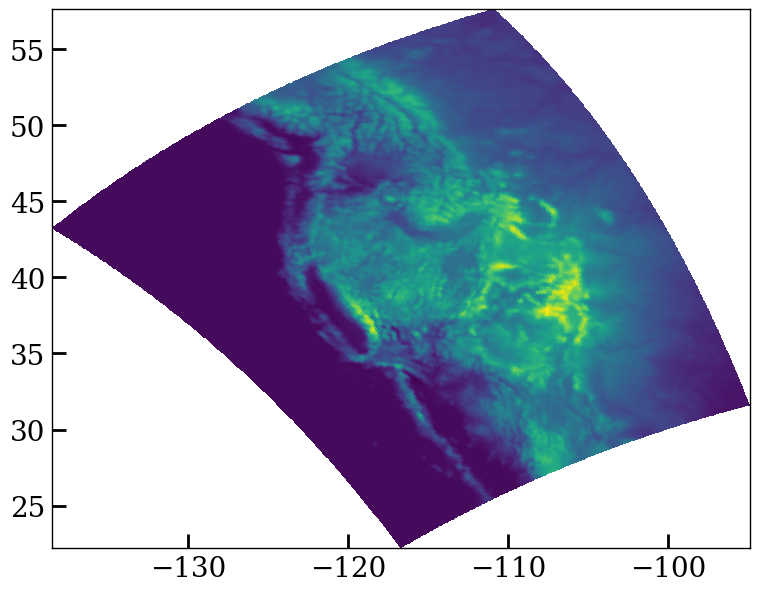

In [6]:
plt.pcolormesh(lon[0], lat[0], z[0])

In [7]:

# Select the elevation data variable and convert it to a numpy array
elevation = z[0]

## 

In [8]:
import dask
# Select the subset of the dataset within the day range and take the average
# Calculate the elevation bands and their corresponding area
snow_by_elev_bin = []
area_by_elev_bin = []
elevation_min = elevation.min()
elevation_max = elevation.max()
elevation_step = 100
elevation_data= elevation.data
elevation_bins = np.arange(elevation_min, elevation_max + elevation_step, elevation_step)
mask = np.logical_and(elevation_data >= elevation_bins[:-1, np.newaxis, np.newaxis], elevation_data < elevation_bins[1:, np.newaxis, np.newaxis])

for i in range(12):
    y1 = 1980 + (10 * i)
    day_start = f"{y1}-10-01"
    day_end = f"{y1+10}-09-30"
    swe_sorted = swe.sortby('day')
    day_start = np.datetime64(day_start)
    day_end = np.datetime64(day_end)

    # Select the subset of the dataset within the day range
    subset = swe_sorted.sel(day=slice(day_start, day_end))

    # Take the average of the "swe" variable across all days in the subset
    average_swe = subset["swe"].mean(dim="day").compute()

    with dask.config.set(scheduler='threads'):
        snow = (average_swe.data * mask).sum(axis = (1,2))
        area = mask.sum(axis = (1,2))
    # Calculate the cumulative area and snow
    #cumulative_snow = np.cumsum(snow)
    snow_by_elev_bin.append(snow)
    area_by_elev_bin.append(area)


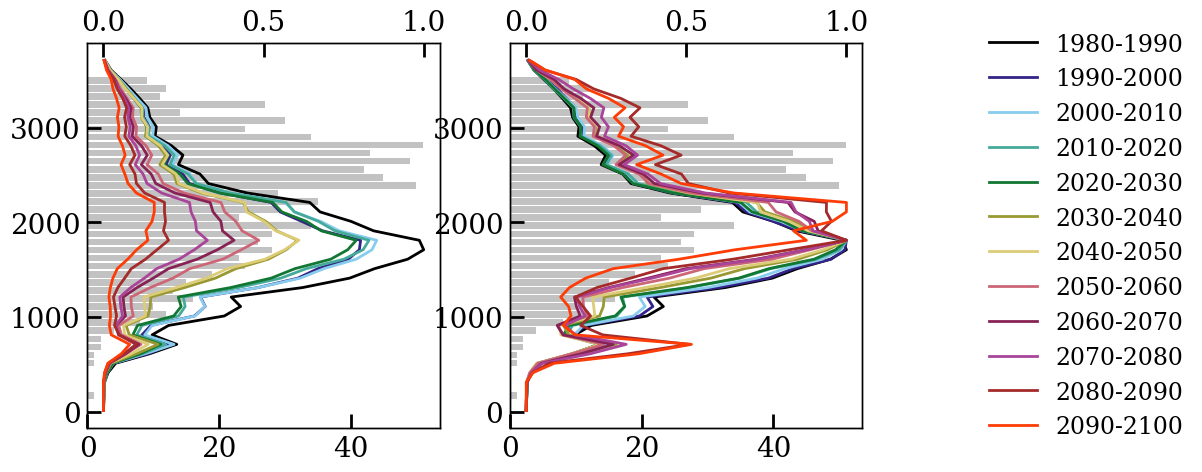

In [45]:
# Plot the hypsometric curve

ft_to_m= 0.3048
fig,ax = plt.subplots(1,2, figsize = (10,5))
ax0 = ax[0]
ax1 = ax[1]
ax02 = ax0.twiny()
ax12 = ax1.twiny()
hist, edges = np.histogram(snotel_no_ak.elev * ft_to_m, bins=40)
# Create horizontal bar plot
# y_pos = np.arange(len(edges)-1) * max(elevation_bins) * ft_to_m / 40 
y_pos = [(edges[i+1] + edges[i])/2 for i in range(len(edges)-1)]
ax0.barh(y_pos , hist,height = 70,align='center', color='darkgray', alpha=0.7)
ax1.barh(y_pos, hist, height = 70, align='center', color='darkgray', alpha=0.7)

yrs = range(1980,2100, 10)
for i,data in enumerate(snow_by_elev_bin):
    #print(i)
    ax02.plot(data / np.nanmax(snow_by_elev_bin), elevation_bins[1:], label = f'{yrs[i]}-{yrs[i]+10}', zorder=-1)
    ax12.plot(data / np.nanmax(data), elevation_bins[1:],  label = f'{yrs[i]}-{yrs[i]+10}', zorder=-1)

#ax02.set_ylabel('Elevation (m)')
#ax12.set_xlabel('Cumulative proportion')
#ax02.set_ylim((0,1.1))
#ax12.set_ylim((0,1.1))
#ax02.tick_params(axis='y', which='both', length=0) 
#ax1.set_yticklabels([])
#ax02.set_yticklabels([])
ax12.legend(frameon=False, bbox_to_anchor=(1.3, 0.5), loc='center left') 
plt.show()


In [52]:
## regionally

subregions = ["SW","SCR","NCR","PNW","ALL"]
bound_arrays = [[35., 42., -121., -114.],
               [35., 42., -114., -105.],
               [42., 49., -117., -107.],
               [42., 49., -125., -117.],
               [35,49,-125,-105]]
lat_array = lat.data
lon_array = lon.data
regionmasks = []
for bounds in bound_arrays:
    lat_min, lat_max, lon_min, lon_max = bounds
    mask = (lat_array >= lat_min) & (lat_array <= lat_max) & \
           (lon_array >= lon_min) & (lon_array <= lon_max)
    regionmasks.append(mask)
    
snow_by_elev_bin = {}
area_by_elev_bin = {}
for subregion in subregions:
    snow_by_elev_bin[subregion] = []
    area_by_elev_bin[subregion] = []
elevation_min = elevation.min()
elevation_max = elevation.max()
elevation_step = 100
elevation_data= elevation.data
elevation_bins = np.arange(elevation_min, elevation_max + elevation_step, elevation_step)

## elevation mask
mask = np.logical_and(elevation_data >= elevation_bins[:-1, np.newaxis, np.newaxis], elevation_data < elevation_bins[1:, np.newaxis, np.newaxis])

for i in range(12):
        y1 = 1980 + (10 * i)
        day_start = f"{y1}-10-01"
        day_end = f"{y1+10}-09-30"
        swe_sorted = swe.sortby('day')
        day_start = np.datetime64(day_start)
        day_end = np.datetime64(day_end)

        # Select the subset of the dataset within the day range
        subset = swe_sorted.sel(day=slice(day_start, day_end))

        # Take the average of the "swe" variable across all days in the subset
        average_swe = subset["swe"].mean(dim="day").compute()

        for i,regmask in enumerate(regionmasks):
            subregion = subregions[i]
            with dask.config.set(scheduler='threads'):
                snow = (average_swe.data * mask * regmask).sum(axis = (1,2))
                area = mask.sum(axis = (1,2))
            snow_by_elev_bin[subregion].append(snow)
            area_by_elev_bin[subregion].append(area)


In [65]:
snotels_by_subregion = {}
for i,bounds in enumerate(bound_arrays):
    lat_min, lat_max, lon_min, lon_max = bounds
    snotels_by_subregion[subregions[i]] = snotel_no_ak[(snotel_no_ak.lat > lat_min) &
                                                       (snotel_no_ak.lat < lat_max) & 
                                                       (snotel_no_ak.lon > lon_min) & 
                                                       (snotel_no_ak.lon < lon_max)]


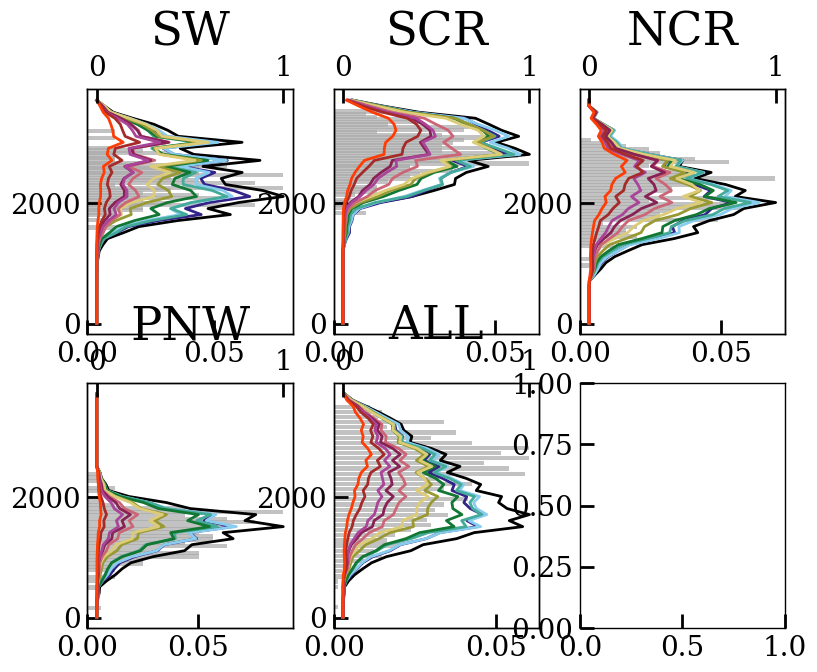

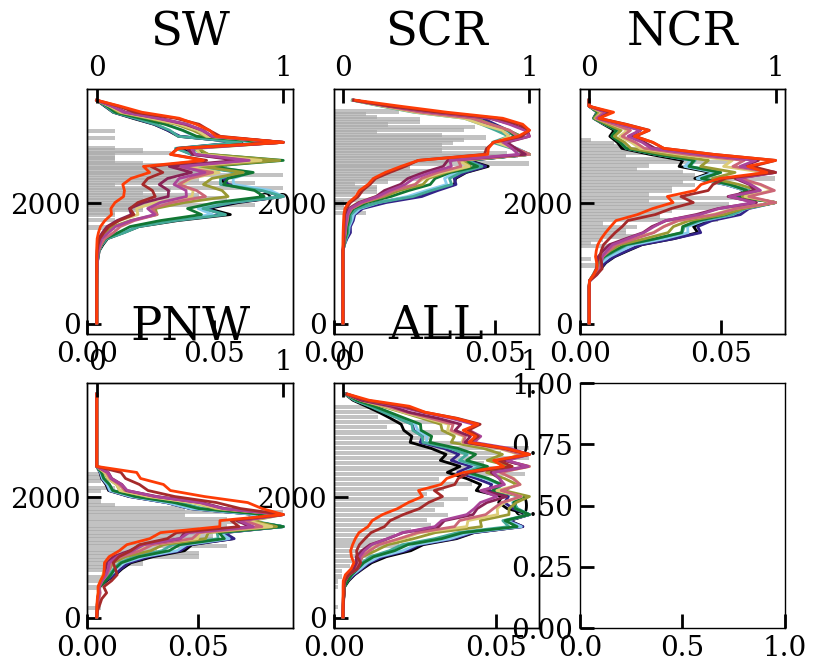

In [73]:
fig,axs = plt.subplots(2,3)
axs = axs.flatten()

for i, subregion in enumerate(subregions):
    ax = axs[i]
    ax2 = ax.twiny()
    snotels = snotels_by_subregion[subregion]
    hist, edges = np.histogram(snotels.elev * ft_to_m, bins=40)
    y_pos = [(edges[i+1] + edges[i])/2 for i in range(len(edges)-1)]
    ax.barh(y_pos , hist / len(snotels),height = 70,align='center', color='darkgray', alpha=0.7)
    snowdata = snow_by_elev_bin[subregion]
    for j,data in enumerate(snowdata):
        ax2.plot(data / np.nanmax(snowdata), elevation_bins[1:], label = f'{yrs[i]}-{yrs[i]+10}', zorder=-1)
    ax.set_title(subregion)
    
    
fig,axs = plt.subplots(2,3)
axs = axs.flatten()

for i, subregion in enumerate(subregions):
    ax = axs[i]
    ax2 = ax.twiny()
    snotels = snotels_by_subregion[subregion]
    hist, edges = np.histogram(snotels.elev * ft_to_m, bins=40)
    y_pos = [(edges[i+1] + edges[i])/2 for i in range(len(edges)-1)]
    ax.barh(y_pos , hist / len(snotels),height = 70,align='center', color='darkgray', alpha=0.7)
    snowdata = snow_by_elev_bin[subregion]
    for j,data in enumerate(snowdata):
        ax2.plot(data / np.nanmax(data), elevation_bins[1:], label = f'{yrs[i]}-{yrs[i]+10}', zorder=-1)
    ax.set_title(subregion)
    

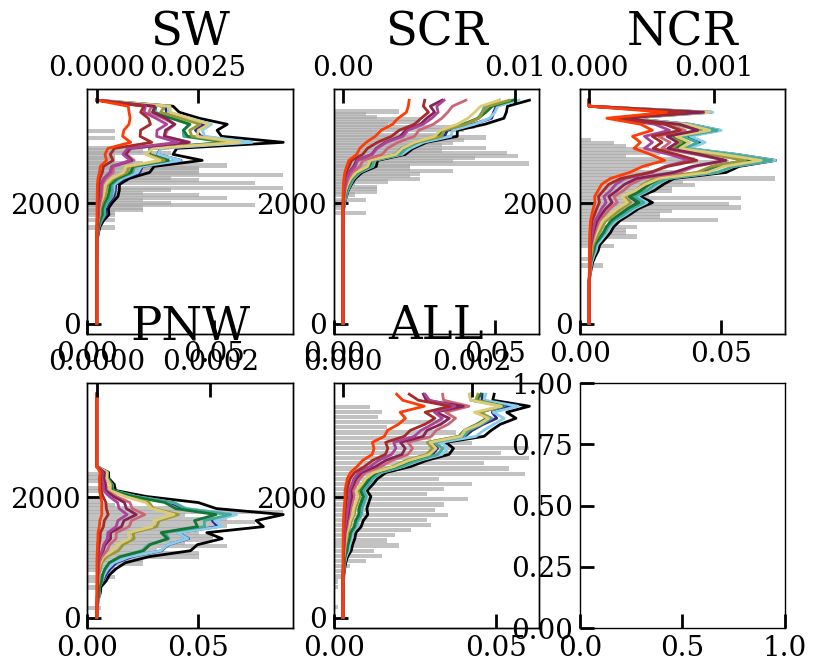

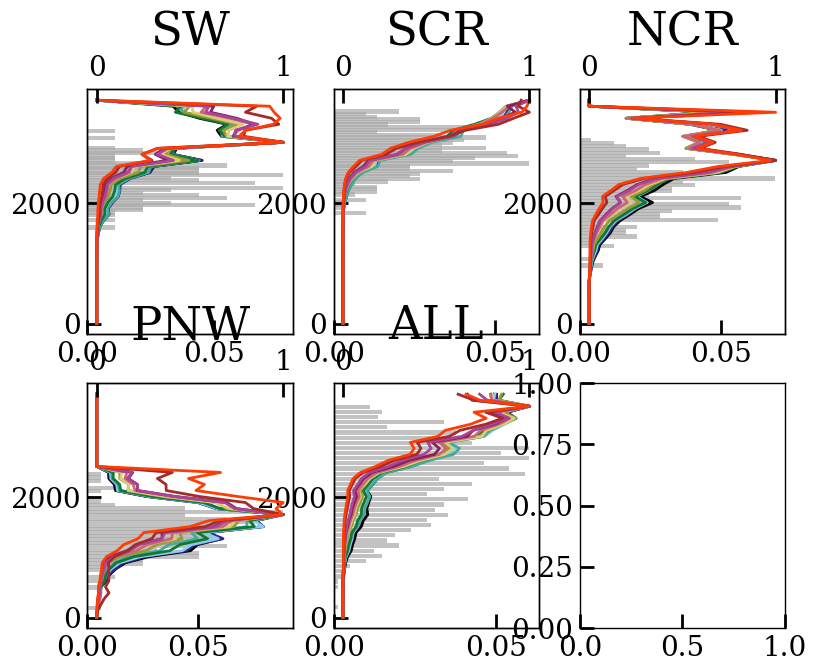

In [76]:
fig,axs = plt.subplots(2,3)
axs = axs.flatten()

for i, subregion in enumerate(subregions):
    ax = axs[i]
    ax2 = ax.twiny()
    snotels = snotels_by_subregion[subregion]
    hist, edges = np.histogram(snotels.elev * ft_to_m, bins=40)
    y_pos = [(edges[i+1] + edges[i])/2 for i in range(len(edges)-1)]
    ax.barh(y_pos , hist / len(snotels),height = 70,align='center', color='darkgray', alpha=0.7)
    snowdata = snow_by_elev_bin[subregion]
    areadata = area_by_elev_bin[subregion]
    plotdata = np.array(snowdata)/np.array(areadata)
    for j,data in enumerate(plotdata):
        ax2.plot(data / np.nanmax(snowdata), elevation_bins[1:], label = f'{yrs[i]}-{yrs[i]+10}', zorder=-1)
    ax.set_title(subregion)
    
    
fig,axs = plt.subplots(2,3)
axs = axs.flatten()

for i, subregion in enumerate(subregions):
    ax = axs[i]
    ax2 = ax.twiny()
    snotels = snotels_by_subregion[subregion]
    hist, edges = np.histogram(snotels.elev * ft_to_m, bins=40)
    y_pos = [(edges[i+1] + edges[i])/2 for i in range(len(edges)-1)]
    ax.barh(y_pos , hist / len(snotels),height = 70,align='center', color='darkgray', alpha=0.7)
    snowdata = snow_by_elev_bin[subregion]
    areadata = area_by_elev_bin[subregion]
    plotdata = np.array(snowdata)/np.array(areadata)
    for j,data in enumerate(plotdata):
        ax2.plot(data / np.nanmax(data), elevation_bins[1:], label = f'{yrs[i]}-{yrs[i]+10}', zorder=-1)
    ax.set_title(subregion)
    

{'SW': [array([0.00000000e+00, 6.66937194e-06, 3.07267401e-05, 6.25705812e-04,
         2.41977219e-02, 3.22027773e-01, 6.61422968e-01, 3.60211945e+00,
         3.71080732e+00, 2.13129787e+01, 2.75150890e+01, 6.84503555e+01,
         1.26322716e+02, 3.04353210e+02, 5.28456177e+02, 1.31959460e+03,
         2.06771924e+03, 3.96629297e+03, 6.56368164e+03, 5.46590918e+03,
         6.96660059e+03, 9.16347168e+03, 8.15736816e+03, 6.32122949e+03,
         6.11573438e+03, 7.14391992e+03, 5.21920312e+03, 8.02040771e+03,
         4.76312305e+03, 4.09837939e+03, 7.13734521e+03, 4.01049951e+03,
         3.48910254e+03, 2.80701636e+03, 1.76359302e+03, 8.03129761e+02,
         3.97393463e+02, 0.00000000e+00], dtype=float32),
  array([0.0000000e+00, 1.7288741e-05, 6.3213938e-06, 1.6466517e-04,
         1.2963509e-02, 8.8762373e-02, 4.6798503e-01, 3.3388314e+00,
         4.0810781e+00, 2.1309635e+01, 2.2234495e+01, 4.9673294e+01,
         7.6416748e+01, 1.8794440e+02, 3.6687350e+02, 9.8023743e+02,
   

In [43]:
y_pos

[170.71086000000003,
 256.10058000000004,
 341.4903,
 426.88002,
 512.26974,
 597.65946,
 683.04918,
 768.4389,
 853.82862,
 939.21834,
 1024.60806,
 1109.9977800000001,
 1195.3875,
 1280.77722,
 1366.16694,
 1451.5566600000002,
 1536.9463799999999,
 1622.3361,
 1707.72582,
 1793.11554,
 1878.50526,
 1963.89498,
 2049.2847,
 2134.67442,
 2220.06414,
 2305.45386,
 2390.8435799999997,
 2476.2333,
 2561.62302,
 2647.01274,
 2732.4024600000002,
 2817.79218,
 2903.1819,
 2988.5716199999997,
 3073.96134,
 3159.35106,
 3244.74078,
 3330.1305,
 3415.52022,
 3500.90994]

In [197]:
# Plot the hypsometric curve
for j in range(len(snow_ranges)+1):
    fig,ax = plt.subplots()
    ax2 = ax.twinx()
    ax.hist(snotel_no_ak.elev * ft_to_m, bins =20, color = 'darkgray', alpha = 0.7)
    ax.set_ylabel('Number of stations')
    yrs = range(1980,2100, 10)
    for i,data in enumerate(snow_ranges[0:j]):
        ax2.plot(elevation_bins[1:], data/ np.nanmax(snow_ranges), label = f'{yrs[i]}-{yrs[i]+10}', zorder=-1)
    ax2.set_xlabel('Elevation (m)')
    ax2.set_ylabel('Cumulative proportion')
    ax.set_xlim((500,4000))
    ax2.set_ylim((0,1.1))
    ax2.legend(frameon=False, bbox_to_anchor=(1.2, 1.0), loc='upper left') 
    fig.savefig(f'../plots/hyp_{j}.png')
    plt.close()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


'../plots/hyp_0-1_12.png'

In [180]:
len(snow_ranges)

12

In [51]:


# Calculate the elevation bands and their corresponding area
elevation_min = elevation.min()
elevation_max = elevation.max()
elevation_step = 100
elevation_bins = np.arange(elevation_min, elevation_max + elevation_step, elevation_step)
area = np.zeros_like(elevation_bins)
snow = np.zeros_like(elevation_bins)
for i in range(len(elevation_bins)-1):
    mask = np.logical_and(elevation >= elevation_bins[i], elevation < elevation_bins[i+1])
    area[i+1] = np.count_nonzero(mask)
    snow[i+1] = np.nansum(average_swe.where(mask))

# Calculate the cumulative area
cumulative_area = np.cumsum(area)
cumulative_snow = np.cumsum(snow)


KeyboardInterrupt: 

In [66]:
average_swe

<xarray.DataArray 'swe' (lat2d: 340, lon2d: 270)>
dask.array<mean_agg-aggregate, shape=(340, 270), dtype=float32, chunksize=(340, 270), chunktype=numpy.ndarray>
Dimensions without coordinates: lat2d, lon2d

In [61]:
tmp = average_swe.compute() #.where(mask)

KeyboardInterrupt: 

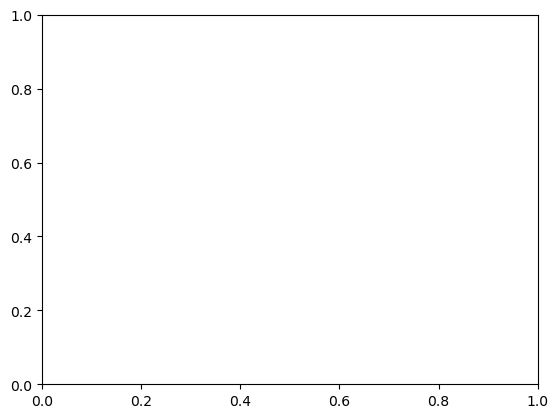

In [62]:
plt.pcolormesh(tmp.where(mask))

In [65]:
snow_average

NameError: name 'snow_average' is not defined

In [156]:

def calculate_yearly_snow_distribution(elevation_data, snow_data):
    elevation_snow = xr.Dataset({"elevation": elevation_data, "snow": snow_data})
    elevation_snow = elevation_snow.stack(z=("x", "y"))

    elevation_bins = np.arange(elevation_snow.elevation.min(), elevation_snow.elevation.max(), 100)
    bin_labels = (elevation_bins[:-1] + elevation_bins[1:]) / 2

    elevation_snow["elevation_bin"] = xr.DataArray(np.digitize(elevation_snow.elevation, elevation_bins), dims="z")
    snow_sum = elevation_snow.groupby("time.year").groupby("elevation_bin").snow.sum().load()

    return bin_labels, snow_sum

def plot_yearly_hypsometric_curve(bin_labels, yearly_snow_sum):
    for year, snow_sum in yearly_snow_sum.groupby("year"):
        plt.plot(bin_labels, snow_sum, label=f"Year {int(year)}")

    plt.xlabel("Elevation (m)")
    plt.ylabel("Cumulative snow")
    plt.legend()
    plt.title("Yearly hypsometric curve of snow")
    plt.show()

In [167]:
elevation_data = data.HGT[0]
snow_data = swe.swe
new_coords = {"lat2d": "y", "lon2d": "x"}
snow_data = snow_data.rename(new_coords)


bin_labels, yearly_snow_sum = calculate_yearly_snow_distribution(elevation_data, snow_data)
plot_yearly_hypsometric_curve(bin_labels, yearly_snow_sum)


ValueError: different number of dimensions on data and dims: 2 vs 1

In [36]:
average_swe

<xarray.DataArray 'swe' (lat2d: 340, lon2d: 270)>
dask.array<mean_agg-aggregate, shape=(340, 270), dtype=float32, chunksize=(340, 270), chunktype=numpy.ndarray>
Dimensions without coordinates: lat2d, lon2d

In [46]:
swe.sel(day = slice('1980-09-01T00:00:00.000000000','2000-09-01T00:00:00.000000000'))

KeyError: "cannot represent labeled-based slice indexer for coordinate 'day' with a slice over integer positions; the index is unsorted or non-unique"

In [15]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

def calculate_snow_distribution(elevation_data, snow_data):
    elevation_snow = xr.Dataset({"elevation": elevation_data, "snow": snow_data})
    elevation_snow = elevation_snow.stack(z=("x", "y"))

    elevation_bins = np.arange(elevation_snow.elevation.min(), elevation_snow.elevation.max(), 100)
    bin_labels = (elevation_bins[:-1] + elevation_bins[1:]) / 2

    elevation_snow["elevation_bin"] = xr.DataArray(np.digitize(elevation_snow.elevation, elevation_bins), dims="z")
    snow_sum = elevation_snow.groupby("elevation_bin").snow.sum().load()

    return bin_labels, snow_sum

def plot_hyposometric_curve(bin_labels, snow_sum):
    plt.plot(bin_labels, snow_sum, label="Snow distribution")
    plt.xlabel("Elevation (m)")
    plt.ylabel("Cumulative snow")
    plt.legend()
    plt.title("Hyposometric curve of snow")
    plt.show()



In [47]:
snow_data = swe['swe'].mean(dim = 'day')

In [51]:
swe['y'] = swe.lat2d
swe['x'] = swe.lon2d

In [89]:
swe.y 

<xarray.DataArray 'y' (lat2d: 340)>
array([  0,   1,   2, ..., 337, 338, 339])
Dimensions without coordinates: lat2d

In [99]:
snowdata = swe['swe'][0]

In [97]:
zdata = z.data[0]
x_data = np.arange(270)
y_data = np.arange(340)

In [100]:
zdata.shape

(340, 270)

In [102]:
# Create xarray DataArrays for the coordinates and the variable
x_coords = xr.DataArray(xdata, dims=("x",), name="x")
y_coords = xr.DataArray(ydata, dims=("y",), name="y")
z_variable = xr.DataArray(zdata, dims=("y", "x"), coords={"x": x_coords, "y": y_coords}, name="z")

# Create a Dataset with the variable 'z'
zdataset = z_variable.to_dataset()

In [70]:
snowdata = snowdata.rename({'lat2d':'y', 'lon2d':'x'})


ValueError: cannot rename 'lat2d' because it is not a variable or dimension in this dataset

In [103]:
bin_labels, snow_sum = calculate_snow_distribution(zdataset, snowdata)
plot_hyposometric_curve(bin_labels, snow_sum)

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_array()` method.

In [117]:
snow_data = snowdata.compute()
elevation_data = zdataset.to_array()[0]
elevation_snow = xr.Dataset({"elevation": elevation_data, "snow": snow_data})
elevation_snow = elevation_snow.stack(z=("x", "y"))

elevation_bins = np.arange(elevation_snow.elevation.min(), elevation_snow.elevation.max(), 100)
bin_labels = (elevation_bins[:-1] + elevation_bins[1:]) / 2

elevation_snow["elevation_bin"] = xr.DataArray(np.digitize(elevation_snow.elevation, elevation_bins), dims="z")
snow_sum = elevation_snow.groupby('elevation_bin').sum().load().snow

In [121]:
snow_sum.shape

(38, 340, 270)

ValueError: x and y must have same first dimension, but have shapes (37,) and (38, 340, 270)

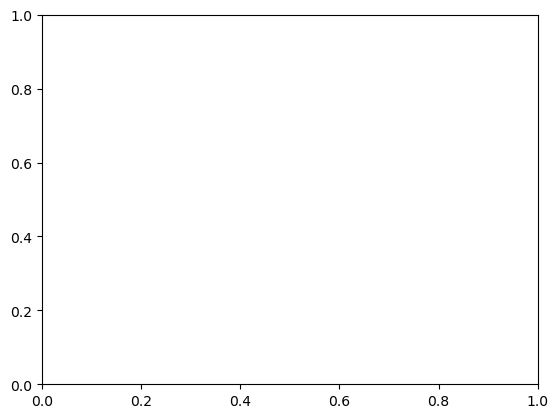

In [118]:
plt.plot(bin_labels, snow_sum, label="Snow distribution")
plt.xlabel("Elevation (m)")
plt.ylabel("Cumulative snow")
plt.legend()
plt.title("Hyposometric curve of snow")
plt.show()

In [134]:
grouped = elevation_snow.groupby('elevation_bin').mean()

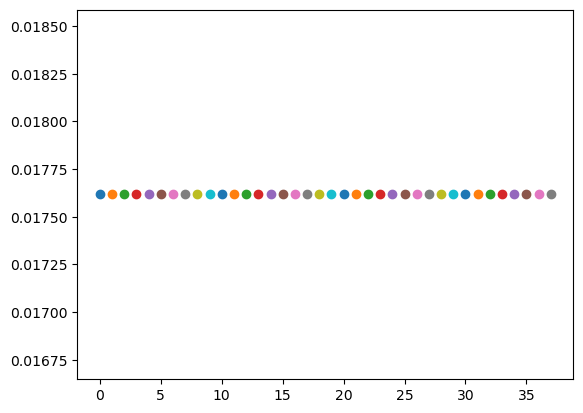

In [155]:
for i in range(38):
    tmp = grouped.snow[i]
    plt.scatter(i, np.nanmean(tmp.data))

In [154]:
tmp

<xarray.DataArray 'snow' (lat2d: 340, lon2d: 270)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    variable       <U1 'z'
    day            datetime64[ns] 1980-09-01
    elevation_bin  int64 1
Dimensions without coordinates: lat2d, lon2d
Attributes:
    average_op_ncl:  dim_avg_n function was applied
    FieldType:       104
    MemoryOrder:     XY 
    description:     SNOW WATER EQUIVALENT
    units:           mm
    stagger:         
    coordinates:     XLONG XLAT XTIME

<xarray.Dataset>
Dimensions:        (elevation_bin: 38, lat2d: 340, lon2d: 270)
Coordinates:
    variable       <U1 'z'
    day            datetime64[ns] 1980-09-01
  * elevation_bin  (elevation_bin) int64 1 2 3 4 5 6 7 ... 32 33 34 35 36 37 38
Dimensions without coordinates: lat2d, lon2d
Data variables:
    elevation      (elevation_bin) float32 nan nan nan nan ... nan nan nan nan
    snow           (elevation_bin, lat2d, lon2d) float32 nan nan nan ... nan nan

In [109]:
elevation_data[0]

<xarray.DataArray (y: 340, x: 270)>
array([[  0.     ,   0.     ,   0.     , ..., 109.15493, 113.61469,
        115.125  ],
       [  0.     ,   0.     ,   0.     , ..., 115.125  , 115.125  ,
        115.125  ],
       [  0.     ,   0.     ,   0.     , ..., 115.125  , 115.125  ,
        115.125  ],
       ...,
       [  0.     ,   0.     ,   0.     , ..., 380.30045, 407.62872,
        434.95377],
       [  0.     ,   0.     ,   0.     , ..., 378.875  , 394.1395 ,
        418.541  ],
       [  0.     ,   0.     ,   0.     , ..., 382.58832, 380.3003 ,
        398.58902]], dtype=float32)
Coordinates:
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 332 333 334 335 336 337 338 339
    variable  <U1 'z'

In [106]:
elevation_snow.elevation

<xarray.DataArray 'elevation' (variable: 1, z: 91800)>
array([[  0.     ,   0.     ,   0.     , ..., 434.95377, 418.541  ,
        398.58902]], dtype=float32)
Coordinates:
  * variable  (variable) object 'z'
    day       datetime64[ns] 1980-09-01
  * z         (z) object MultiIndex
  * x         (z) int64 0 0 0 0 0 0 0 0 0 ... 269 269 269 269 269 269 269 269
  * y         (z) int64 0 1 2 3 4 5 6 7 8 ... 332 333 334 335 336 337 338 339